# Partitioning Strategy for Federated Learning (Region-Based Clients)

**Objective:**
Explain how the eICU dataset is partitioned into clients for federated learning and ensure that each partition maintains a reasonable balance between prolonged and non-prolonged ICU stays.

**Context:**
The goal is to classify whether an ICU stay is **prolonged** (≥ 3 days). In federated learning, data remains separated across multiple clients, so the way we partition the dataset directly affects model performance, data balance, and fairness.

**Key Questions:**
1. How are ICU stays distributed across U.S. regions?
2. Does splitting into Midwest, South, and “Other” create three meaningful federated clients?
3. Does each client retain a similar proportion of prolonged stays?
4. Are any partitions too small or too imbalanced to support useful local training?

**High-Level Approach:**
1. Load essential patient and hospital fields:
   - `patientunitstayid`, `hospitalid`, `region`, `unitdischargeoffset`
2. Compute ICU length of stay in days and create the binary label (`prolonged_stay = 1` if LOS ≥ 3).
3. Examine regional distributions to understand how ICU stays are spread geographically.
4. Assign regions to federated clients:
   - **Client A:** Midwest
   - **Client B:** South
   - **Client C:** West + Northeast + Unknown
5. For each client, evaluate:
   - Total ICU stays
   - Prolonged-stay proportion
   - Visual checks for imbalance where appropriate

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# Plotting settings
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. Connect to Database

In [3]:
# Connect to DuckDB database
db_path = '../../data/duckdb/fedlearn.duckdb'
conn = duckdb.connect(db_path, read_only=True)

print(f"Connected to database: {db_path}")

Connected to database: ../../data/duckdb/fedlearn.duckdb


## 2. Load Core ICU Stay + Hospital Region Data

Load the key information needed for partitioning: each ICU stay, the hospital it belongs to, and the hospital’s region.

In [4]:
query = """
SELECT
    p.patientunitstayid,
    p.hospitalid,
    h.region,
    p.unitadmittime24,
    p.unitdischargeoffset
FROM patient AS p
LEFT JOIN hospital AS h
    ON p.hospitalid = h.hospitalid
"""

df = conn.execute(query).df()

print("Raw ICU stay + region data")
print("=" * 60)
print(df.head())
print(f"\nTotal ICU stays loaded: {len(df):,}")
print(f"Distinct hospitals: {df['hospitalid'].nunique():,}")
print(f"Distinct regions (raw): {df['region'].unique()}")

Raw ICU stay + region data
   patientunitstayid  hospitalid   region unitadmittime24  unitdischargeoffset
0             141168          59  Midwest        15:54:00                 3596
1             141178          60  Midwest        09:10:00                    8
2             141179          60  Midwest        09:18:00                 2042
3             141194          73  Midwest        07:18:00                 4813
4             141196          67  Midwest        22:00:00                 1463

Total ICU stays loaded: 200,859
Distinct hospitals: 208
Distinct regions (raw): ['Midwest' None 'South' 'West' 'Northeast']


## 3. Compute ICU Length of Stay and Binary Target

ICU length of stay is calculated by converting the discharge offset from minutes into days. This gives a continuous measure of how long each patient stayed in the ICU.

A threshold of 3 days is used to define a prolonged stay, which aligns with earlier analysis and keeps the target label consistent across notebooks. Using this threshold, a binary variable is created:

- `icu_los_days` – length of stay in days
- `prolonged_stay` – 1 if LOS ≥ 3 days, otherwise 0

In [5]:
# Compute ICU length of stay in days
df["icu_los_days"] = df["unitdischargeoffset"] / 1440.0  # 60 * 24

# Binary target: prolonged stay (>= 3 days)
PROLONGED_THRESHOLD_DAYS = 3.0
df["prolonged_stay"] = (df["icu_los_days"] >= PROLONGED_THRESHOLD_DAYS).astype(int)

# Basic sanity checks
print("ICU LOS (days) summary:")
print("=" * 60)
print(df["icu_los_days"].describe())

overall_rate = df["prolonged_stay"].mean()
print(f"\nOverall prolonged stay rate (>= {PROLONGED_THRESHOLD_DAYS} days): {overall_rate:.3f}")
print(f"Prolonged stays: {df['prolonged_stay'].sum():,}")
print(f"Non-prolonged stays: {(1 - df['prolonged_stay']).sum():,}")

ICU LOS (days) summary:
count   200859.000
mean         2.679
std          4.331
min         -5.338
25%          0.819
50%          1.574
75%          2.972
max        506.372
Name: icu_los_days, dtype: float64

Overall prolonged stay rate (>= 3.0 days): 0.246
Prolonged stays: 49,465
Non-prolonged stays: 151,394


## 4. Overall Class Balance: Prolonged vs Non-Prolonged

Review the distribution of `prolonged_stay` and calculate the overall proportion of prolonged stays.

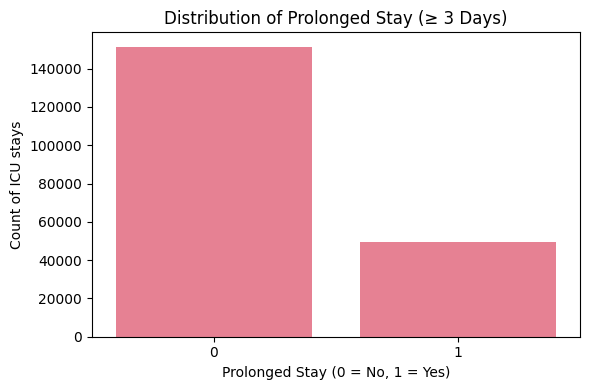

Overall prolonged stay rate: 0.246


In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="prolonged_stay")
plt.title(f"Distribution of Prolonged Stay (≥ {PROLONGED_THRESHOLD_DAYS:.0f} Days)")
plt.xlabel("Prolonged Stay (0 = No, 1 = Yes)")
plt.ylabel("Count of ICU stays")
plt.tight_layout()
plt.show()

overall_rate = df["prolonged_stay"].mean()
print(f"Overall prolonged stay rate: {overall_rate:.3f}")

## 5. Define Region-Based Federated Clients

### Why partition by region?

Federated learning requires dividing the data into meaningful groups that are large enough for local training. Using hospital region provides a practical way to create distinct clients while preserving geographic structure and avoiding extreme differences between partitions.

### Chosen partitioning scheme

The dataset is divided into three clients:

- **Client A:** Midwest
- **Client B:** South
- **Client C:** Other (West, Northeast, Unknown)

This approach maintains reasonable client sizes and reflects natural regional groupings within the dataset.

In [7]:
def assign_client(region: str) -> str:
    """
    Map hospital region to a synthetic 'client' for federated learning.

    - Midwest      -> client_midwest
    - South        -> client_south
    - Everything else (West, Northeast, Unknown, etc.) -> client_other
    """
    if region == "Midwest":
        return "client_midwest"
    elif region == "South":
        return "client_south"
    else:
        return "client_other"

df["client"] = df["region"].apply(assign_client)

client_counts = (
    df["client"]
    .value_counts()
    .rename_axis("client")
    .to_frame("num_stays")
    .reset_index()
)

print("ICU stays per client")
print("=" * 60)
print(client_counts.to_string(index=False))

ICU stays per client
        client  num_stays
  client_other      74615
client_midwest      65950
  client_south      60294


## 6. Class Balance by Client

After assigning each ICU stay to a client, the next step is to check whether the proportion of prolonged stays is similar across clients. Large differences could lead to uneven learning during federated training.

For each client, the total number of stays and the proportion of prolonged stays are calculated, followed by a simple visualization to compare class balance across groups.

Class balance by client
        client  num_stays  num_prolonged  prolonged_rate
client_midwest      65950          16780           0.254
  client_other      74615          16197           0.217
  client_south      60294          16488           0.273


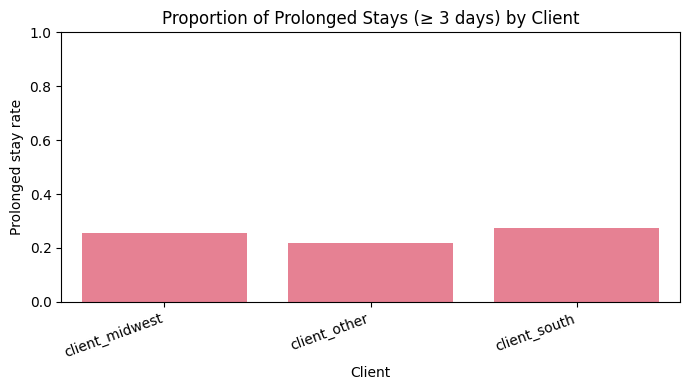

In [8]:
client_summary = (
    df.groupby("client")["prolonged_stay"]
    .agg(
        num_stays="count",
        num_prolonged="sum",
    )
    .reset_index()
)

client_summary["prolonged_rate"] = (
    client_summary["num_prolonged"] / client_summary["num_stays"]
)

print("Class balance by client")
print("=" * 60)
print(client_summary.to_string(index=False))

# Bar plot of prolonged rate per client
plt.figure(figsize=(7, 4))
sns.barplot(data=client_summary, x="client", y="prolonged_rate")
plt.title(f"Proportion of Prolonged Stays (≥ {PROLONGED_THRESHOLD_DAYS:.0f} days) by Client")
plt.xlabel("Client")
plt.ylabel("Prolonged stay rate")
plt.ylim(0, 1)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

## 7. Region-Level Detail Within Each Client

To better understand variation within each client, it is useful to look at how regions are distributed inside each partition and whether certain regions have noticeably different prolonged-stay rates.

A simple breakdown of prolonged-stay proportions by both client and region helps identify whether any internal differences may influence model behavior.

In [10]:
# Make sure missing regions are labeled explicitly
df["region"] = df["region"].fillna("Unknown")

client_region_summary = (
    df.groupby(["client", "region"])["prolonged_stay"]
    .agg(
        num_stays="count",
        num_prolonged="sum",
    )
    .reset_index()
)

client_region_summary["prolonged_rate"] = (
    client_region_summary["num_prolonged"] / client_region_summary["num_stays"]
)

print("Class balance by client and region")
print("=" * 80)
print(
    client_region_summary
    .sort_values(["client", "region"])
    .to_string(index=False)
)

Class balance by client and region
        client    region  num_stays  num_prolonged  prolonged_rate
client_midwest   Midwest      65950          16780           0.254
  client_other Northeast      14429           4356           0.302
  client_other   Unknown      13838           3013           0.218
  client_other      West      46348           8828           0.190
  client_south     South      60294          16488           0.273


## 8. Interpretation and Implications for Federated Modeling

**Region-based grouping:**
Using hospital region to form clients provides a clear and structured way to divide the data. It creates partitions that reflect meaningful differences across hospitals while keeping the setup consistent with the rest of the analysis.

**Three clients with sufficient data:**
Combining West, Northeast, and Unknown regions into a single client helps avoid very small groups. This keeps each client large enough to be useful in federated training and maintains a manageable number of partitions.

**Class balance check:**
The summaries above show the overall prolonged-stay rate and how each client compares to that baseline. This helps confirm that the partitions do not introduce major label imbalances, which is important for stable training and fair model evaluation.

Overall, the partitioning strategy results in clients that are well-sized, aligned with the available metadata, and consistent with the needs of the federated learning setup.

In [11]:
# Close connection
conn.close()
print("Database connection closed.")

Database connection closed.
